# Forecasting and feature engineering with TSFresh


We start with standart importing, from influxdb we import DataFrameClient to get response as pandas df.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from influxdb import DataFrameClient

Time Series FeatuRe Extraction on basis of Scalable Hypothesis tests (tsfresh – A Python package) https://www.sciencedirect.com/science/article/pii/S0925231218304843

For tsfresh features extraction parameters we want to use dict with settings or builtin minimal parameters for quick tests of our setup.

In [51]:
from tsfresh import defaults, extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters

In [52]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

In [53]:
from sklearn.ensemble import AdaBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [63]:
%load_ext watermark

In [64]:
%watermark -v -m --iversions

matplotlib.pylab1.15.4
IPython   5.0.0
pandas    0.23.4
numpy     1.15.4
tsfresh   0.11.1
CPython 3.6.7
IPython 5.0.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.15.0-43-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


## Define influxdb query function
Get ticker data from our db. With DataFrameClient we easily get pd as return.

In [5]:
def get_ticker_data(exchange, symbol):
    '''Get an price data for past hour from the storage
    and return it as pandas dataframe.'''
    client = DataFrameClient('18.182.117.179',8086,'nightly','','')
    myquery = """SELECT last("ask") AS "best_ask", 
                        last("bid") AS "best_bid" 
                     FROM "TKG"."autogen"."ticker_data" 
                     WHERE time > now() - 601m
                     AND time < now() - 1m
                     AND "exchange"='{}' 
                     AND "ticker"='{}' 
                     GROUP BY time(1s) 
                     FILL(previous)""".format(exchange, symbol) # 'binance', 'BTC/USDT'
    raw_data = client.query(myquery)
    ticker_data = pd.DataFrame(raw_data['ticker_data'])
    return ticker_data

## Pull data to construct derivative

Lets define our settings.

In [6]:
exchange = 'binance'
symbol = 'BTC/USDT'
btc_usdt_binance = get_ticker_data(exchange,symbol)

And call our function to get data

In [7]:
tob_data = pd.DataFrame(btc_usdt_binance).dropna()

Lets explore what we get.

In [8]:
tob_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36000 entries, 2019-01-30 01:20:43+00:00 to 2019-01-30 11:20:42+00:00
Data columns (total 2 columns):
best_ask    36000 non-null float64
best_bid    36000 non-null float64
dtypes: float64(2)
memory usage: 843.8 KB


In [9]:
x = pd.DataFrame(tob_data['best_ask']).copy()

x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36000 entries, 2019-01-30 01:20:43+00:00 to 2019-01-30 11:20:42+00:00
Data columns (total 1 columns):
best_ask    36000 non-null float64
dtypes: float64(1)
memory usage: 562.5 KB


So, we have a time series and want to construct a time series model that is able to predict the next data points.

To do that, we have to construct a feature matrix by calculating the features for sub time series (see the forecasting section in the tsfresh documentation).

Create forecasting frame

In [10]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

In [39]:
df_shift, y = make_forecasting_frame(x["best_ask"][:10000], kind="price", max_timeshift=10, rolling_direction=1)

In [40]:
df_shift.head()

time    value                        id   kind
89946 2019-01-30 01:20:43  3399.17 2019-01-30 01:20:44+00:00  price
79948 2019-01-30 01:20:43  3399.17 2019-01-30 01:20:45+00:00  price
89947 2019-01-30 01:20:44  3399.17 2019-01-30 01:20:45+00:00  price
69951 2019-01-30 01:20:43  3399.17 2019-01-30 01:20:46+00:00  price
79949 2019-01-30 01:20:44  3399.17 2019-01-30 01:20:46+00:00  price

In [41]:
df_shift.shape

(99945, 4)

In [42]:
df_shift.to_pickle('df_shift1901')

In [43]:
# import pickle
# f = open('df_shift1901', 'rb')
# loaded_df = pickle.load(f)

df_shift is ready to be passed into the feature extraction process in tsfresh

In [44]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)

In [45]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(9999, 794)
(9999, 293)


In [46]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)

In [47]:
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [48]:
X.head()

variable                   value__abs_energy  value__absolute_sum_of_changes  \
id                                                                             
2019-01-30 01:20:45+00:00       2.310871e+07                            0.00   
2019-01-30 01:20:46+00:00       3.466307e+07                            0.00   
2019-01-30 01:20:47+00:00       4.621743e+07                            0.00   
2019-01-30 01:20:48+00:00       5.777178e+07                            0.00   
2019-01-30 01:20:49+00:00       6.932968e+07                            0.52   

variable                   value__agg_autocorrelation__f_agg_"mean"  \
id                                                                    
2019-01-30 01:20:45+00:00                                     0.000   
2019-01-30 01:20:46+00:00                                     0.000   
2019-01-30 01:20:47+00:00                                     0.000   
2019-01-30 01:20:48+00:00                                     0.000   
2019-01-30 01:20:49+00:00                                    -0.348   

variable                   value__agg_autocorrelation__f_agg_"median"  \
id                                                                      
2019-01-30 01:20:45+00:00                                         0.0   
2019-01-30 01:20:46+00:00                                         0.0   
2019-01-30 01:20:47+00:00                                         0.0   
2019-01-30 01:20:48+00:00                                         0.0   
2019-01-30 01:20:49+00:00                                        -0.2   

variable                   value__agg_autocorrelation__f_agg_"var"  \
id                                                                   
2019-01-30 01:20:45+00:00                                 0.000000   
2019-01-30 01:20:46+00:00                                 0.000000   
2019-01-30 01:20:47+00:00                                 0.000000   
2019-01-30 01:20:48+00:00                                 0.000000   
2019-01-30 01:20:49+00:00                                 0.121216   

variable                   value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"  \
id                                                                                               
2019-01-30 01:20:45+00:00                                            3408.80                     
2019-01-30 01:20:46+00:00                                            3408.80                     
2019-01-30 01:20:47+00:00                                            3408.80                     
2019-01-30 01:20:48+00:00                                            3408.80                     
2019-01-30 01:20:49+00:00                                            3399.17                     

variable                   value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"  \
id                                                                                            
2019-01-30 01:20:45+00:00                                                0.0                  
2019-01-30 01:20:46+00:00                                                0.0                  
2019-01-30 01:20:47+00:00                                                0.0                  
2019-01-30 01:20:48+00:00                                                0.0                  
2019-01-30 01:20:49+00:00                                                1.0                  

variable                   value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"  \
id                                                                                           
2019-01-30 01:20:45+00:00                                               0.00                 
2019-01-30 01:20:46+00:00                                               0.00                 
2019-01-30 01:20:47+00:00                                               0.00                 
2019-01-30 01:20:48+00:00                                               0.00                 
2019-01-30 01:20:49+0

# Fit Adaboost

In [49]:
from tqdm import tqdm # progress bar for Python and CLI https://tqdm.github.io

In [50]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y) 

isp = 100   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|██████████| 9898/9898 [6:08:28<00:00,  5.02s/it]  


As you can see with only: 
10000 last best_ask on 1 sec precision,
max_timeshift=10 while creating forecasting frame,
n_estimators=10 at regressor params
and isp = 100 as sliding window
it takes more then 6 hours to finish on mentioned above environment.

In [54]:
y_pred.to_pickle('y_pred_best_ask_1901')

In [69]:
y_pred.tail()

2019-01-30 04:07:18+00:00    3424.679109
2019-01-30 04:07:19+00:00    3424.713475
2019-01-30 04:07:20+00:00    3424.600398
2019-01-30 04:07:21+00:00    3424.360117
2019-01-30 04:07:22+00:00    3425.009814
dtype: float64

In [129]:
# Dataframe of predictions and true values
yss = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})
ys= yss.tail(10000)
# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()

pred     true
2019-01-30 01:20:45+00:00   NaN  3399.17
2019-01-30 01:20:46+00:00   NaN  3399.17
2019-01-30 01:20:47+00:00   NaN  3399.17
2019-01-30 01:20:48+00:00   NaN  3399.69
2019-01-30 01:20:49+00:00   NaN  3399.69

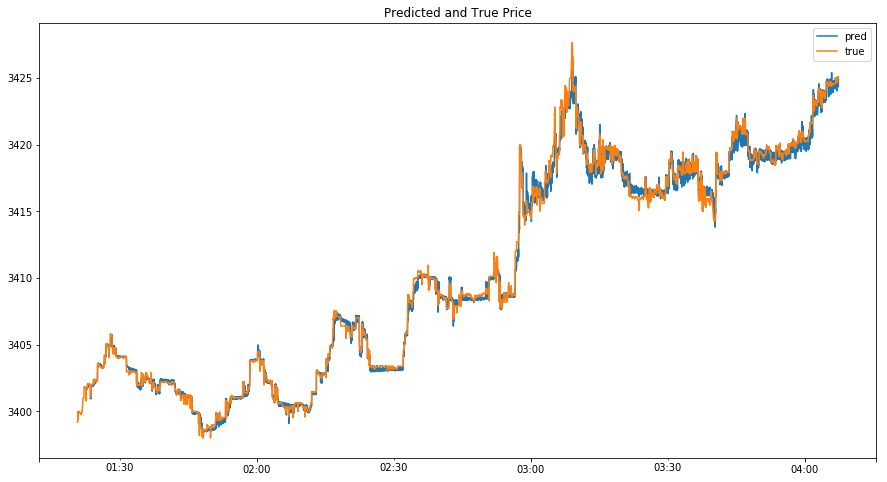

In [130]:
ys.plot(figsize=(15, 8))
plt.title('Predicted and True Price')
plt.show()

Looks not so good. The blue curve is the output of the AdaBoost Regressor, the orange curve is the true best ask offer.

Now, we will also inspect last value before the prediction as a benchmark tool, denoted by y-1



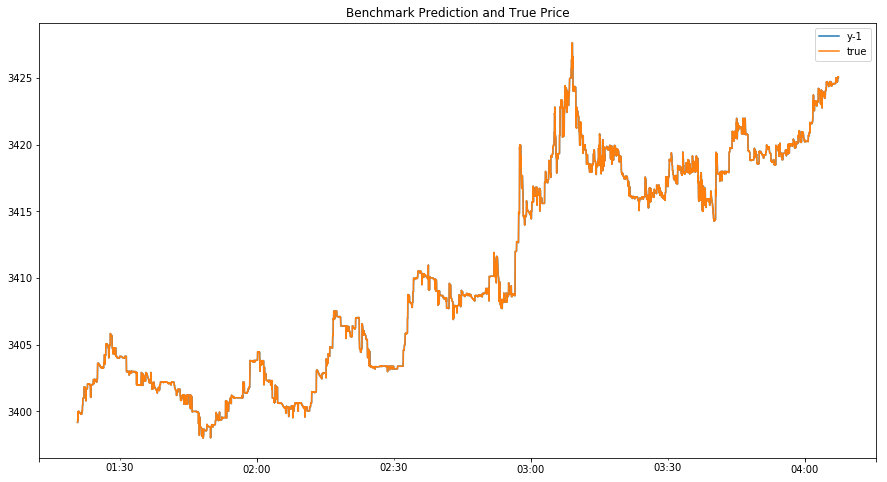

In [132]:
# Create column of previous price
ys['y-1'] = ys['true'].shift(1)
ys[['y-1', 'true']].tail(10000).plot(figsize = (15, 8))
plt.title('Benchmark Prediction and True Price')
plt.show()

In [60]:
def MSE(Y, YH):
     return np.square(np.abs(Y - YH)).mean()

In [118]:
def MAE(Y, YH):
    return np.abs(Y - YH).mean()

In [62]:
print("MAE y-1: \t{}".format(np.mean(np.abs(np.diff(y))[isp-1:] )))
print("MAE ada: \t{}".format(np.mean(np.abs(y_pred - y)[isp:])))

print("MSE y-1: \t{}".format(np.square(np.abs(np.diff(y))[isp-1:] ).mean()))
print("MSE ada: \t{}".format(np.square(np.abs(y_pred - y)[isp:]).mean()))

MAE y-1: 	0.05819458476459829
MAE ada: 	0.32330928240550794
MSE y-1: 	0.04328036977166994
MSE ada: 	0.2301283300692916


However, we are not yet beating the y-1 benchmark, so we need to invest more time into building dedicated features or use a better model.

We can also inspect the relevance of the extracted features



In [72]:
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(6)

variable
feature_last_value                                               0.713905
value__maximum                                                   0.159868
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_2     0.122123
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_5     0.002052
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10    0.001300
value__c3__lag_1                                                 0.000752
dtype: float64

feature_last_value is our shift-1

In [ ]:
def maximum(x):
    """
    Calculates the highest value of the time series x.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    return np.max(x)

<a href="http://repository.urosario.edu.co/bitstream/handle/10336/18360/1010193305-2018.pdf?sequence=1&isAllowed=y">Wavelet analysis on financial time series</a> 

We can learn more about wavelets from this article <a href='https://habr.com/ru/post/168517/'>Вейвлет-сжатие «на пальцах»</a>

<a href='https://github.com/nekrasovp/gaps'>Genetic Algorithm based solver for jigsaw puzzles with piece size auto-detection</a> as example of genetic approach to image data manipulation

In [ ]:
def cwt_coefficients(x, param):
    """
    Calculates a Continuous wavelet transform for the Ricker wavelet, also known as the "Mexican hat wavelet" which is
    defined by

    .. math::
        \\frac{2}{\\sqrt{3a} \\pi^{\\frac{1}{4}}} (1 - \\frac{x^2}{a^2}) exp(-\\frac{x^2}{2a^2})

    where :math:`a` is the width parameter of the wavelet function.

    This feature calculator takes three different parameter: widths, coeff and w. The feature calculater takes all the
    different widths arrays and then calculates the cwt one time for each different width array. Then the values for the
    different coefficient for coeff and width w are returned. (For each dic in param one feature is returned)

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param param: contains dictionaries {"widths":x, "coeff": y, "w": z} with x array of int and y,z int
    :type param: list
    :return: the different feature values
    :return type: pandas.Series
    """

    calculated_cwt = {}
    res = []
    indices = []

    for parameter_combination in param:
        widths = parameter_combination["widths"]
        w = parameter_combination["w"]
        coeff = parameter_combination["coeff"]

        if widths not in calculated_cwt:
            calculated_cwt[widths] = cwt(x, ricker, widths)

        calculated_cwt_for_widths = calculated_cwt[widths]

        indices += ["widths_{}__coeff_{}__w_{}".format(widths, coeff, w)]

        i = widths.index(w)
        if calculated_cwt_for_widths.shape[1] <= coeff:
            res += [np.NaN]
        else:
            res += [calculated_cwt_for_widths[i, coeff]]

    return zip(indices, res)

<a href="https://www.macalester.edu/~kaplan/knoxville/PRE05443.pdf">Discrimination power of measures for nonlinearity in a time series</a>

In [ ]:
def c3(x, lag):
    """
    This function calculates the value of

    .. math::

        \\frac{1}{n-2lag} \sum_{i=0}^{n-2lag} x_{i + 2 \cdot lag}^2 \cdot x_{i + lag} \cdot x_{i}

    which is

    .. math::

        \\mathbb{E}[L^2(X)^2 \cdot L(X) \cdot X]

    where :math:`\\mathbb{E}` is the mean and :math:`L` is the lag operator. It was proposed in [1] as a measure of
    non linearity in the time series.

    .. rubric:: References

    |  [1] Schreiber, T. and Schmitz, A. (1997).
    |  Discrimination power of measures for nonlinearity in a time series
    |  PHYSICAL REVIEW E, VOLUME 55, NUMBER 5

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param lag: the lag that should be used in the calculation of the feature
    :type lag: int
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    n = x.size
    if 2 * lag >= n:
        return 0
    else:
        return np.mean((np.roll(x, 2 * -lag) * np.roll(x, -lag) * x)[0:(n - 2 * lag)])



Conclusion. 

When we were creating forecasted frame we use only 10 timeshift while for better understanding 100 will be more informative. 

We used feature extraction to 794 recommendet features.

Then we fit our features with adaboostregressor with sliding window 100 which have to be greater to get better result.

Finally we get 3 more features which we will add to hand maded to use for forecasting.